## 统计方法实验四--多重共线性--10215501435 杨茜雅


In [1]:
from sklearn.datasets import load_diabetes
import sas7bdat
import os

import pandas as pd
import numpy as np
import random
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

from sklearn import preprocessing # Data Preprocessing
import statsmodels.api as sm # LSE, Ridge Regression
from statsmodels.stats.outliers_influence import variance_inflation_factor # VIF 
from statsmodels.multivariate.pca import PCA # PCR

from jupyterquiz import display_quiz 

## 数据预处理

### 1、 从scikit-learn包中载入数据集diabetes

### 我们先来看一下原始数据集

In [2]:
Data = pd.read_csv("./Data/diabetes.csv")
print(Data.head())

        age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  target  
0 -0.002592  0.019907 -0.017646   151.0  
1 -0.039493 -0.068332 -0.092204    75.0  
2 -0.002592  0.002861 -0.025930   141.0  
3  0.034309  0.022688 -0.009362   206.0  
4 -0.002592 -0.031988 -0.046641   135.0  


我们可以简单统计一下这个数据集中的一些基本信息，如样本量、特征维度，即

In [3]:
p = Data.shape[1]-1
n = Data.shape[0]

print("The number of features is",p)
print("The sample size is",n)

The number of features is 10
The sample size is 442


### 我们再来看一下参考文献二中的"二次模型"SAS数据集

In [4]:
path = r"/home/jovyan/Stat_ML_2023/Data/diabetes2.sas7bdat"
Data = sas7bdat.SAS7BDAT(path,encoding='gb2312').to_data_frame()

In [5]:
print(Data)

          age       sex       bmi       map        tc       ldl       hdl  \
0    0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1   -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2    0.085299  0.050680  0.044451 -0.005671 -0.045599 -0.034194 -0.032356   
3   -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4    0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   
..        ...       ...       ...       ...       ...       ...       ...   
437  0.041708  0.050680  0.019662  0.059744 -0.005697 -0.002566 -0.028674   
438 -0.005515  0.050680 -0.015906 -0.067642  0.049341  0.079165 -0.028674   
439  0.041708  0.050680 -0.015906  0.017282 -0.037344 -0.013840 -0.024993   
440 -0.045472 -0.044642  0.039062  0.001215  0.016318  0.015283 -0.028674   
441 -0.045472 -0.044642 -0.073030 -0.081414  0.083740  0.027809  0.173816   

          tch       ltg       glu  ...   ldl_tch   ldl_ltg   ldl_glu  \
0  

我们可以简单统计一下这个数据集中的一些基本信息，如样本量、特征维度，即

In [6]:
p = Data.shape[1]-1
n = Data.shape[0]
print("The number of features is",p)
print("The sample size is",n)

The number of features is 64
The sample size is 442


### 2、 通过阅读以下参考文献，定义清楚问题背景、数据中响应变量和自变量的概念、取值范围等信息。

### 答：

原始数据一次项为10项，它们为特征（或自变量），分别为AGE SEX BMI BP S1 S2 S3 S4 S5 S6，另外有Y为响应变量(或标签）,这 10 个特征变量中的每一个均已以均值为中心，并按标准差乘以平方根n_samples（即每列的平方和总计为 1）进行缩放

在SAS数据集中，二次项共64项，包括前十项以及其交叉项，最后加上一列响应变量Y。

问题背景：本数据集是对 442 名糖尿病患者中的每一位进行了十项基线变量、年龄、性别、体重指数、平均血压和六项血清测量，以及感兴趣的反应，一年后疾病进展的定量测量基线

### 3、 以学号的最后三位数字作为随机种子，采用留出法划分训练集和测试集，样本比例为7.5:2.5。

In [7]:
n_train = 331 # 75% * n
n_test = n-n_train
seed = 435
random.seed(seed)
index = range(0,n)
index_selected = random.sample(index,n_train)
index_selected.sort()

Data_train = Data.loc[index_selected]
Data_test = Data.drop(index = index_selected)

In [8]:
Data_train.head()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,...,ldl_tch,ldl_ltg,ldl_glu,hdl_tch,hdl_ltg,hdl_glu,tch_ltg,tch_glu,ltg_glu,y
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,...,-0.022038,-0.031125,-0.000922,0.033494,0.000852,0.031150,-0.028191,-0.017658,-0.027794,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,...,-0.011564,0.012973,0.023783,-0.023815,-0.094506,-0.140378,0.025298,0.053034,0.104013,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,...,-0.022063,-0.018016,0.004913,0.032956,0.018281,0.032795,-0.027332,-0.017236,-0.022304,141.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,...,-0.024091,-0.026846,-0.029687,0.030984,0.014489,0.005386,-0.025575,-0.016180,0.008735,135.0
5,-0.092695,-0.044642,-0.040696,-0.019442,-0.068991,-0.079288,0.041277,-0.076395,-0.041180,-0.096346,...,0.071719,0.056037,0.149663,-0.027844,-0.018031,-0.075513,0.033999,0.126147,0.057789,97.0


In [9]:
Data_test.head()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,...,ldl_tch,ldl_ltg,ldl_glu,hdl_tch,hdl_ltg,hdl_glu,tch_ltg,tch_glu,ltg_glu,y
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,...,-0.009984,-0.003373,-0.019109,0.008159,0.001898,0.021514,-0.012045,-0.024872,-0.025042,206.0
6,-0.045472,0.050680,-0.047163,-0.015999,-0.040096,-0.024800,0.000779,-0.039493,-0.062913,-0.038357,...,-0.008066,0.018496,0.006298,0.030803,0.019267,0.013254,0.021137,0.011224,0.026986,138.0
7,0.063504,0.050680,-0.001895,0.066630,0.090620,0.108914,0.022869,0.017703,-0.035817,0.003064,...,0.006841,-0.101758,-0.006939,0.038984,0.001868,0.015502,-0.039520,-0.017491,-0.023007,63.0
8,0.041708,0.050680,0.061696,-0.040099,-0.013953,0.006202,-0.028674,-0.002592,-0.014956,0.011349,...,-0.023709,-0.017902,-0.012585,0.032777,0.030064,0.006608,-0.026433,-0.019136,-0.024196,110.0
11,0.027178,0.050680,0.017506,-0.033214,-0.007073,0.045972,-0.065491,0.071210,-0.096433,-0.059067,...,0.027982,-0.113478,-0.072303,-0.056210,0.163067,0.100925,-0.160745,-0.101251,0.092040,69.0


In [10]:
X_train = Data_train.drop(columns = ['y'],axis=1)
Y_train = Data_train.y
X_test = Data_test.drop(columns = ["y"],axis=1)
Y_test = Data_test.y

# X_train_standardized=X_train.values

X_train_standardized = preprocessing.scale(X_train, with_mean = True, with_std=True)/np.sqrt(n_train)
Y_train_centered = preprocessing.scale(Y_train, with_mean = True, with_std=False)
Y_train_mean = np.average(Y_train)
X_test_standardized = preprocessing.scale(X_test, with_mean = True, with_std=True)/np.sqrt(n_test)
print(X_train_standardized)

[[ 0.04275517  0.05682299  0.0695996  ... -0.03308919 -0.02206755
  -0.03332875]
 [-0.0028028  -0.05316771 -0.0584812  ...  0.02603656  0.05346515
   0.10772014]
 [ 0.09659641  0.05682299  0.05008252 ... -0.03213928 -0.02161644
  -0.02745387]
 ...
 [-0.00694442  0.05682299 -0.01822723 ... -0.04534373  0.00903242
  -0.04297067]
 [ 0.0468968   0.05682299 -0.01822723 ... -0.02081312 -0.02663377
  -0.04127843]
 [-0.0525024  -0.05316771 -0.08287754 ... -0.02839675 -0.02557071
  -0.02615341]]


## 模型构建
### 在本次实验中我们将a quantitative measure of disease progression one year after baseline作为响应变量，构建合适的特征（可参考文献2），并训练模型。

#### 参考文献二，所以我使用增加了二次变量的SAS数据集来构建模型

### 4、 判断用于建模的特征数据中是否存在多重共线性？提供合适的判断方案。

##  Method 1

### 热力图观察

首先可以通过热力图来观察一下特征之间的自身相关性。

<Axes: >

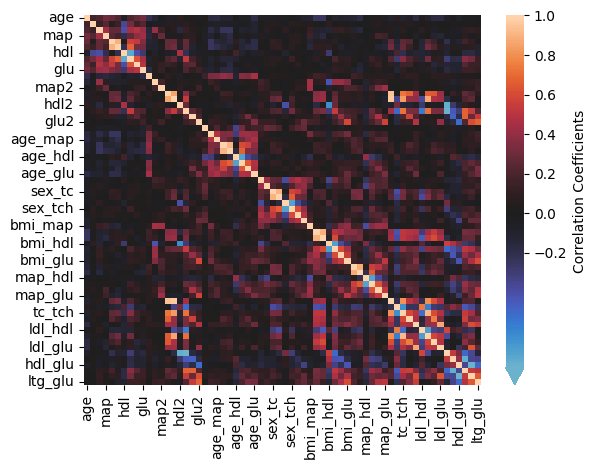

In [11]:
pcorr = X_train.corr(method = 'pearson')
tick_ = (np.arange(0,13,2)-2)/10
dict_ = {"orientation":'vertical',
         'label':'Correlation Coefficients',
         "drawedges":False,
         "ticklocation":"top",
         "extend":"min",
        #"filled":True,
         "alpha":0.8,
         "cmap":"cmap",
         "ticks":tick_}
sns.heatmap(pcorr,cbar_kws= dict_,center=0)

### 因为自变量数量过多，具体关系无法看得很清楚，但是从浅色区域可以观察到，相邻自变量之间存在相关性。

##  Method 2

### 方差扩大因子法(设置临界值为 5)

In [12]:
vif_cv = 5 # The criterion value of VIF

1. 根据方差扩大因子的定义，可以通过矩阵计算来确定方差扩大因子。

In [13]:
# Method One
C = np.linalg.inv(np.dot(X_train_standardized.T,X_train_standardized))
VIF_1 = np.diag(C)
print("The VIF's are", np.round(VIF_1,2))

The VIF's are [1.62000000e+00 1.50000000e+00 2.79000000e+00 2.02000000e+00
 1.71312995e+06 1.33468125e+06 2.32881930e+05 2.75000000e+01
 1.92126810e+05 1.96000000e+00 1.75000000e+00 2.58000000e+00
 1.79000000e+00 2.33861700e+04 1.40088700e+04 9.95900000e+02
 1.51940000e+02 1.45882000e+03 3.85000000e+00 1.91000000e+00
 2.61000000e+00 2.27000000e+00 1.34500000e+02 8.76500000e+01
 2.75000000e+01 1.70000000e+01 1.77300000e+01 2.57000000e+00
 2.34000000e+00 2.08000000e+00 1.25840000e+02 7.96400000e+01
 2.62300000e+01 1.49400000e+01 1.94400000e+01 2.10000000e+00
 3.01000000e+00 1.72180000e+02 1.19170000e+02 4.72700000e+01
 2.37700000e+01 2.40100000e+01 3.75000000e+00 1.73270000e+02
 1.26450000e+02 3.66600000e+01 1.63000000e+01 2.88200000e+01
 3.36000000e+00 6.68380600e+04 5.90189000e+03 1.26878000e+03
 8.40417700e+04 1.32640000e+02 4.07591000e+03 9.02910000e+02
 5.89152400e+04 9.60800000e+01 3.61910000e+02 9.77766000e+03
 3.26800000e+01 1.62730000e+02 2.32900000e+01 3.02500000e+01]


2. 使用Python中statsmodel包中的自带函数variance_inflation_factor。

In [14]:
# Method Two
VIF_2 = [variance_inflation_factor(X_train_standardized[:,0:p], i) for i in range(p)]
print("The VIF's are", np.round(VIF_2,2))

The VIF's are [1.62000000e+00 1.50000000e+00 2.79000000e+00 2.02000000e+00
 1.71312995e+06 1.33468126e+06 2.32881930e+05 2.75000000e+01
 1.92126810e+05 1.96000000e+00 1.75000000e+00 2.58000000e+00
 1.79000000e+00 2.33861700e+04 1.40088700e+04 9.95900000e+02
 1.51940000e+02 1.45882000e+03 3.85000000e+00 1.91000000e+00
 2.61000000e+00 2.27000000e+00 1.34500000e+02 8.76500000e+01
 2.75000000e+01 1.70000000e+01 1.77300000e+01 2.57000000e+00
 2.34000000e+00 2.08000000e+00 1.25840000e+02 7.96400000e+01
 2.62300000e+01 1.49400000e+01 1.94400000e+01 2.10000000e+00
 3.01000000e+00 1.72180000e+02 1.19170000e+02 4.72700000e+01
 2.37700000e+01 2.40100000e+01 3.75000000e+00 1.73270000e+02
 1.26450000e+02 3.66600000e+01 1.63000000e+01 2.88200000e+01
 3.36000000e+00 6.68380600e+04 5.90189000e+03 1.26878000e+03
 8.40417700e+04 1.32640000e+02 4.07591000e+03 9.02910000e+02
 5.89152400e+04 9.60800000e+01 3.61910000e+02 9.77766000e+03
 3.26800000e+01 1.62730000e+02 2.32900000e+01 3.02500000e+01]


可以观察到使用method1和method2计算出来的方差扩大因子是一样的。

In [15]:
# Method Three
X_5 = X_train_standardized[:,4]
X_others = X_train_standardized[:,5:p]
model_vif = sm.OLS(X_5,X_others).fit()
X_5_VIF = 1/(1-model_vif.rsquared)
print("The VIF of the fifth feature is", np.round(X_5_VIF,2))

The VIF of the fifth feature is 1697473.79


这里选取前五个自变量，可以发现其方差扩大因子超级大，远大于临界值，说明其多重共线性是严重的。

##  Method 3

### 特征值方法

通过计算 𝐗′𝐗 的特征值来判断数据多重共线性的程度。

In [16]:
R = np.dot(X_train_standardized.T,X_train_standardized)
W, V = np.linalg.eig(R)
W = -1* np.sort(-1*W)
W_diag = np.diag(W)
V = V.T
print("The eigen values are", np.round(W,4))

The eigen values are [1.10341e+01 6.10960e+00 5.29100e+00 3.96370e+00 3.48650e+00 2.96780e+00
 2.57210e+00 2.44700e+00 2.04570e+00 1.90290e+00 1.79230e+00 1.45940e+00
 1.39700e+00 1.25510e+00 1.18600e+00 1.09240e+00 1.03940e+00 9.43600e-01
 8.26500e-01 7.69900e-01 7.32500e-01 7.24800e-01 6.68000e-01 6.24600e-01
 6.17600e-01 5.86500e-01 5.61200e-01 5.35800e-01 4.90900e-01 4.69000e-01
 4.52200e-01 4.41700e-01 4.10400e-01 3.57800e-01 3.34700e-01 3.04600e-01
 2.65900e-01 2.48400e-01 2.41300e-01 2.19000e-01 1.93000e-01 1.81200e-01
 1.62100e-01 1.59000e-01 9.65000e-02 8.50000e-02 5.53000e-02 4.71000e-02
 3.17000e-02 2.87000e-02 2.24000e-02 2.02000e-02 1.36000e-02 1.04000e-02
 6.30000e-03 4.60000e-03 3.90000e-03 3.30000e-03 2.60000e-03 2.30000e-03
 1.70000e-03 4.00000e-04 0.00000e+00 0.00000e+00]


In [17]:
Condition_Number = np.sqrt(np.max(W)/np.min(W))
print("The condition number is",np.round(Condition_Number,4))

The condition number is 6392.9182


In [18]:
model_ols = sm.OLS(Y_train_centered,X_train_standardized).fit()
print("The condition number is",round(model_ols.condition_number,4))

The condition number is 6392.9182


可以发现，这里计算出来的条件值也很大。

### 5、构建线性回归模型Model_1、岭回归模型Model_2、主成分回归模型Model_3

### 构建线性回归模型Model_1

In [19]:
X_train_withintercept = sm.add_constant(X_train)
model_1 = sm.OLS(Y_train,X_train_withintercept).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     6.357
Date:                Thu, 02 Nov 2023   Prob (F-statistic):           1.33e-27
Time:                        03:10:38   Log-Likelihood:                -1755.6
No. Observations:                 331   AIC:                             3641.
Df Residuals:                     266   BIC:                             3888.
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.9564      3.074     49.760      0.000     146.904     159.009
age          -11.3203     78.811     -0.144      0.886    -166.494     143.853
sex         -231.5765     76.733     -3.018      0.003    -382.658     -80.495
bmi          463.9708    102.721      4.517      0.000     261.721     666.220
map          371.4369     88.357      4.204      0.000     197.469     545.405
tc          2897.9556   8.16e+04      0.036      0.972   -1.58e+05    1.64e+05
ldl        -2722.8825   7.17e+04     -0.038      0.970   -1.44e+05    1.39e+05
hdl        -1308.0199   3.05e+04     -0.043      0.966   -6.14e+04    5.88e+04
tch           78.7774    319.941      0.246      0.806    -551.162     708.717
ltg         -354.6107   2.68e+04     -0.013      0.989   -5.32e+04    5.25e+04
glu           88.2148     83.344      1.058      0.291     -75.883     252.312
age2          69.3956     81.186      0.855      0.393     -90.453     229.245
bmi2         123.6581     96.196      1.285      0.200     -65.744     313.060
map2         -16.4148     82.423     -0.199      0.842    -178.699     145.870
tc2         8445.3173   9032.534      0.935      0.351   -9339.040    2.62e+04
ldl2        4881.7277   6917.414      0.706      0.481   -8738.122    1.85e+04
hdl2        2277.9684   1962.520      1.161      0.247   -1586.081    6142.018
tch2         513.4119    704.183      0.729      0.467    -873.070    1899.893
ltg2        1444.2136   2284.445      0.632      0.528   -3053.681    5942.109
glu2           0.4893    112.344      0.004      0.997    -220.707     221.686
age_sex      206.8778     85.373      2.423      0.016      38.785     374.971
age_bmi      -16.1967     96.466     -0.168      0.867    -206.131     173.737
age_map      -26.1159     91.939     -0.284      0.777    -207.138     154.906
age_tc        31.2498    701.422      0.045      0.964   -1349.795    1412.295
age_ldl     -239.0744    565.442     -0.423      0.673   -1352.386     874.237
age_hdl      197.7218    324.232      0.610      0.543    -440.666     836.110
age_tch      171.5627    247.744      0.692      0.489    -316.227     659.352
age_ltg       43.5219    259.290      0.168      0.867    -467.001     554.045
age_glu       95.7251     96.190      0.995      0.321     -93.666     285.116
sex_bmi       60.9185     94.200      0.647      0.518    -124.554     246.391
sex_map      163.5939     89.061      1.837      0.067     -11.760     338.948
sex_tc        66.4258    697.993      0.095      0.924   -1307.868    1440.720
sex_ldl       71.0926    552.736      0.129      0.898   -1017.201    1159.386
sex_hdl      -98.3689    320.551     -0.307      0.759    -729.508     532.770
sex_tch     -268.9975    233.669     -1.151      0.251    -729.074     191.079
sex_ltg        5.2509    268.950      0.020      0.984    -524.290     534.792
se

### 构建岭回归模型Model_2

岭回归估计为
$$
\hat{\mathbf{\beta}}(k) = (\mathbf{X}'\mathbf{X} + k \mathbf{I})^{-1} \mathbf{X}' \mathbf{y}.
$$

使用statmodels.api包中OLS.fit_regularized可以实现。

In [20]:
## Ridge Regression
alpha  = 0.1 # A hyperparameter in Ridge Regression (equivalently but not equally, k in slides)
model_rr = sm.OLS(Y_train_centered,X_train_standardized).fit_regularized(L1_wt=0,alpha = alpha)
print("The parameters in the ridge regression are ",np.round(model_rr.params,2))

The parameters in the ridge regression are  [  6.01   2.14  23.32  16.88   7.42   5.56 -15.02  15.81  21.47  14.86
  -0.65  10.06   6.22   1.1    0.64  -3.6    5.13   3.2    4.63   4.38
  -2.66   2.57  -3.48  -5.54  -1.45   0.19   2.44   2.45   2.6    6.06
   2.63   0.37   2.79   0.14   2.99   2.45   4.61  -1.99  -3.56  -2.07
   3.44   3.41   5.57   0.62  -2.3   -0.1    1.35   4.82   4.13   0.49
  -2.19   2.01   1.42   2.27   1.95   0.11  -3.11   0.03  -1.8   -1.12
  -4.6    3.56   6.47   5.92]


其中超参数 $\alpha=k/n$

In [21]:
alpha_num = 100
alpha_vec = np.array(list(range(0,alpha_num)))/alpha_num/1000
RR_coef = []
RR_vif = []

for alpha in alpha_vec:
    rr_model = sm.OLS(Y_train_centered,X_train_standardized).fit_regularized(L1_wt=0,alpha = alpha)
    rr_coef = rr_model.params
    RR_coef.append(rr_coef)

下面通过岭迹图来去认定最优的超参数。

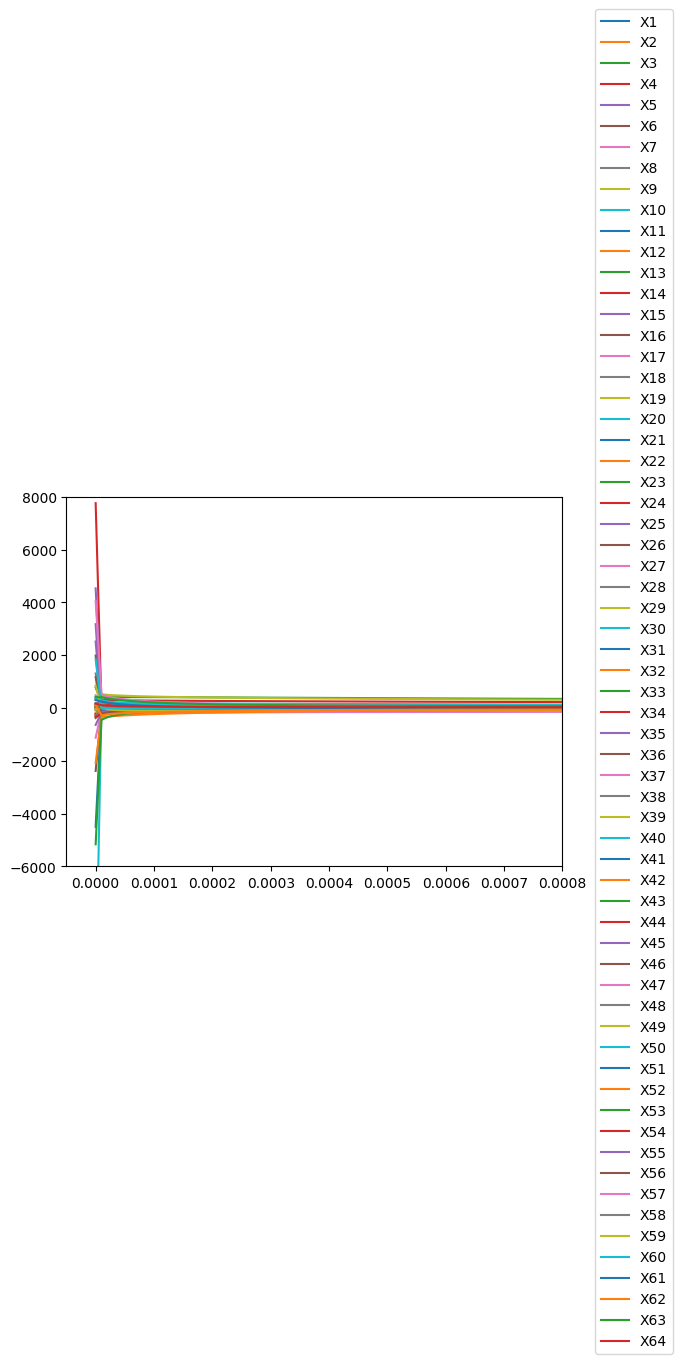

In [22]:
for i in range(p):
    plt.plot(alpha_vec, np.array(RR_coef)[:,i],label = "X%d"%(i+1))

plt.axis([-0.00005,0.0008,-6000,8000])    
plt.legend(loc="right",bbox_to_anchor=(1.25,0.5),borderaxespad=1)


因为自变量过多，从上图也很难直接看出最优的超参数，因此可以计算不同$\alpha$下的VIF值，其复合临界值条件时，可以进行选择。

In [23]:
C_k = []
for alpha in alpha_vec:
    k = alpha * n_train
    c_k = np.linalg.inv(X_train_standardized.T @ X_train_standardized + k * np.eye(p)) @ X_train_standardized.T @ X_train_standardized @ np.linalg.inv(X_train_standardized.T @ X_train_standardized + k * np.eye(p))
    C_k.append(np.mean(np.diag(c_k)))

alpha_best = alpha_vec[np.min(np.where(np.array(C_k) < vif_cv))]
print("The chosen value of alpha is", alpha_best)

The chosen value of alpha is 4e-05


In [24]:
model_rr_best = sm.OLS(Y_train_centered,X_train_standardized).fit_regularized(L1_wt=0,alpha = alpha_best)
model_rr_best_coef = model_rr_best.params
print(model_rr_best_coef)

[ -12.60258374 -180.05234974  414.51376186  295.39884548  -77.36505523
 -104.27207357 -149.94006389  111.1169049   477.09578708   92.79775901
   65.47082681  113.7501245   -12.07507888   36.39986309   14.9268986
   12.94205598   35.4394068   129.87600059   -2.58760797  190.17928284
  -14.88813525   -9.04742184    9.00696229 -183.68638573  172.33163235
  139.93098186   31.4513552    73.35473229   55.54502895  144.92616868
  108.26189578  -10.25810118  -48.50289911 -172.39450276  -44.45666236
   26.36750595   10.1191226  -131.68981578   40.41699163  209.46511966
   65.65620496   -4.39339979   28.51461798   82.22126198  -37.58645663
  -70.45512315  -34.77873775   10.18442287  -53.58976839  160.22351407
  -13.50392215 -290.20464398 -249.81289309 -120.21934947 -113.09457734
 -113.85048528  358.86004372   33.1579435   -81.59211744  -16.76930778
  152.41741984 -199.42843051  309.19608254   74.67579535]


### 构建主成分回归模型Model_3

在PCR模型中，先构建特征的主成分。

In [25]:
model_pca = PCA(X_train_standardized,standardize = False, demean = True)
model_pca_cr = model_pca.eigenvals # contribution rate of each component
print("The percentages of total variance are", np.around(model_pca_cr,4))

The percentages of total variance are [1.10341e+01 6.10960e+00 5.29100e+00 3.96370e+00 3.48650e+00 2.96780e+00
 2.57210e+00 2.44700e+00 2.04570e+00 1.90290e+00 1.79230e+00 1.45940e+00
 1.39700e+00 1.25510e+00 1.18600e+00 1.09240e+00 1.03940e+00 9.43600e-01
 8.26500e-01 7.69900e-01 7.32500e-01 7.24800e-01 6.68000e-01 6.24600e-01
 6.17600e-01 5.86500e-01 5.61200e-01 5.35800e-01 4.90900e-01 4.69000e-01
 4.52200e-01 4.41700e-01 4.10400e-01 3.57800e-01 3.34700e-01 3.04600e-01
 2.65900e-01 2.48400e-01 2.41300e-01 2.19000e-01 1.93000e-01 1.81200e-01
 1.62100e-01 1.59000e-01 9.65000e-02 8.50000e-02 5.53000e-02 4.71000e-02
 3.17000e-02 2.87000e-02 2.24000e-02 2.02000e-02 1.36000e-02 1.04000e-02
 6.30000e-03 4.60000e-03 3.90000e-03 3.30000e-03 2.60000e-03 2.30000e-03
 1.70000e-03 4.00000e-04 0.00000e+00 0.00000e+00]


在计算出$\mathbf{X}'\mathbf{X}$的特征值后，通过代码进行验证。

In [26]:
Corr_Mat = X_train_standardized.T @ X_train_standardized
Lambda, V = np.linalg.eig(Corr_Mat)
Lambda = sorted(Lambda,reverse = True)
print("The eigen values of X'X are ", np.around(Lambda,4))

The eigen values of X'X are  [1.10341e+01 6.10960e+00 5.29100e+00 3.96370e+00 3.48650e+00 2.96780e+00
 2.57210e+00 2.44700e+00 2.04570e+00 1.90290e+00 1.79230e+00 1.45940e+00
 1.39700e+00 1.25510e+00 1.18600e+00 1.09240e+00 1.03940e+00 9.43600e-01
 8.26500e-01 7.69900e-01 7.32500e-01 7.24800e-01 6.68000e-01 6.24600e-01
 6.17600e-01 5.86500e-01 5.61200e-01 5.35800e-01 4.90900e-01 4.69000e-01
 4.52200e-01 4.41700e-01 4.10400e-01 3.57800e-01 3.34700e-01 3.04600e-01
 2.65900e-01 2.48400e-01 2.41300e-01 2.19000e-01 1.93000e-01 1.81200e-01
 1.62100e-01 1.59000e-01 9.65000e-02 8.50000e-02 5.53000e-02 4.71000e-02
 3.17000e-02 2.87000e-02 2.24000e-02 2.02000e-02 1.36000e-02 1.04000e-02
 6.30000e-03 4.60000e-03 3.90000e-03 3.30000e-03 2.60000e-03 2.30000e-03
 1.70000e-03 4.00000e-04 0.00000e+00 0.00000e+00]


通过比对发现，二者的值没有区别。

接下来选择超参数：主成分个数。通过绘制scree plot来进行主观判断。

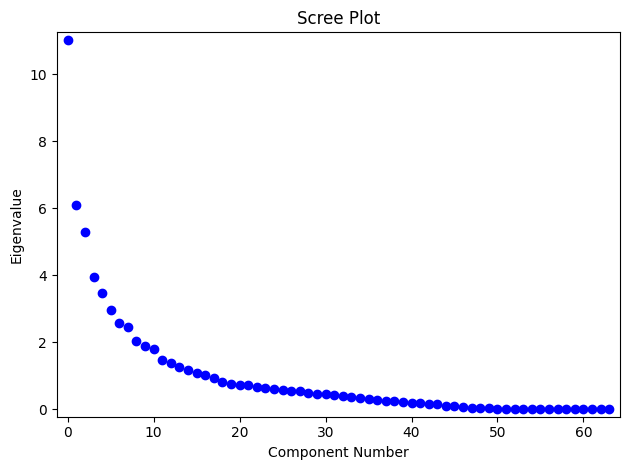

In [27]:
fig = model_pca.plot_scree(log_scale = False)

同时可以计算其信息增量（每增加一个主成分），因此绘制scree plot来观察其累计贡献率。

The cummulative percentages of total variance are [0.1724 0.2679 0.3505 0.4125 0.467  0.5133 0.5535 0.5917 0.6237 0.6534
 0.6814 0.7043 0.7261 0.7457 0.7642 0.7813 0.7975 0.8123 0.8252 0.8372
 0.8487 0.86   0.8704 0.8802 0.8898 0.899  0.9078 0.9161 0.9238 0.9311
 0.9382 0.9451 0.9515 0.9571 0.9623 0.9671 0.9713 0.9751 0.9789 0.9823
 0.9853 0.9882 0.9907 0.9932 0.9947 0.996  0.9969 0.9976 0.9981 0.9986
 0.9989 0.9992 0.9994 0.9996 0.9997 0.9998 0.9998 0.9999 0.9999 1.
 1.     1.     1.     1.    ]


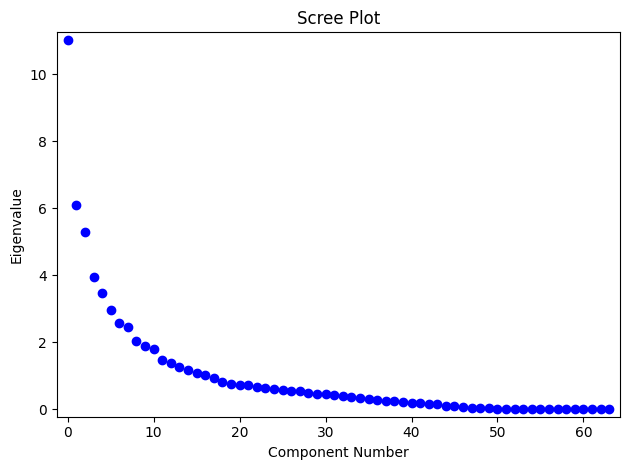

In [28]:
model_pca_ccr = np.cumsum(model_pca_cr)/p # cummulative contribution rate
print("The cummulative percentages of total variance are", np.around(model_pca_ccr,4))

fig = model_pca.plot_scree(log_scale = False)

选取主成分，要求其累计贡献率达到90%。

In [29]:
pca_cv = 0.90

In [30]:
num_pca = np.min(np.where(model_pca_ccr > pca_cv))
print("The appropriate number of component is", (num_pca+1))

The appropriate number of component is 27


最佳主成分个数为27。（虽然正常来说应该不超过6个）

最后构建主成分来代替原始特征，并拟合回归模型；通过线性变换来估计主成分回归中的参数。

In [31]:
model_pca_selected = PCA(X_train_standardized,  standardize = False,  demean = True)
V = model_pca_selected.loadings
Z_train_standardized= X_train_standardized @ V[:,0:(num_pca+1)]
model_pcr = sm.OLS(Y_train_centered, Z_train_standardized).fit()
model_pcr_coef = V.T @ np.pad(model_pcr.params,(0,p-(num_pca+1)))
print(model_pcr_coef)

[  -7.40003964   -0.29840147   37.0722936   -47.99398408  -73.09119981
  -22.88083013   38.76281396  -10.93118416    2.96078244  208.11247613
   -5.38228859  104.13355674  157.43780327   47.30746653  -72.71067498
   14.72268458 -197.0189051   -12.81881559  -16.69648506   -1.42702075
   75.37602008  119.47502934   67.75223967  103.80753443   57.70121211
  103.2380225   -48.62323352   55.10976401 -141.11844565 -127.52008587
  -14.22007911   84.10389327    2.27871168  -76.69729901   29.60922164
  137.14350692  244.67872008   92.92265969  -52.08345577  -23.21745931
   94.88633175  -23.34387196 -129.43605418   -8.28975543  144.21801773
  -25.86297678   -7.92675531   -8.15490649  -42.61526001  -40.90821826
   57.99759654   20.62869192   16.40893275   18.3288203    93.3067998
  112.94321572   63.06182978  105.66453222  -40.18101671   -4.5599626
  -31.47312152   62.95173539  -85.43883109  168.31509031]


## 模型评价

### 6、利用RMSE，比较Model_1、Model_2、Model_3在测试集上的预测效果。请进行评论。

RMSE衡量指标：

$$
RMSE = \sqrt{n^{-1}\sum_{i=1}^n (\hat{y}_i - y_i)^2}
$$

1. 构建线性回归模型。对于每一个数据$(\mathbf{x}_i,y_i)$，线性回归模型的预测结果为
$$
y_i^{\text{ols}} = \hat{\beta}_0 + \mathbf{x}_i \hat{\mathbf{\beta}}^{\text{ols}}
$$
这里
- $\hat{\beta}_0$采用训练集中响应变量的样本均值来估计；
- $\hat{\mathbf{\beta}}^{\text{ols}}$采用最小二乘估计；

In [32]:
model_ols_coef = model_ols.params 
Y_pred_ols = Y_train_mean + X_test_standardized @ model_ols_coef
ols_rmse = np.sqrt(np.mean((Y_pred_ols-Y_test)**2))
print("The RMSE in the ordinary regression is", round(ols_rmse,4))

The RMSE in the ordinary regression is 106.9224


2. 构建岭回归模型。对于每一个数据$(\mathbf{x}_i,y_i)$，岭回归模型的预测结果为
$$
y_i^{\text{rr}} = \hat{\beta}_0 + \mathbf{x}_i \hat{\mathbf{\beta}}^{\text{rr}}
$$
这里
- $\hat{\beta}_0$采用训练集中响应变量的样本均值来估计；
- $\hat{\mathbf{\beta}}^{\text{rr}}$采用岭回归估计；


In [33]:
Y_pred_rr = Y_train_mean + X_test_standardized @ model_rr_best_coef
rr_rmse = np.sqrt(np.mean((Y_pred_rr-Y_test)**2))

print("The RMSE in the ridge regression is", round(rr_rmse,4))
    

The RMSE in the ridge regression is 73.0725


3. 构建主成分回归模型。对于每一个数据$(\mathbf{x}_i,y_i)$，主成分回归模型的预测结果为
$$
y_i^{\text{pcr}} = \hat{\beta}_0 + \mathbf{x}_i \hat{\mathbf{\beta}}^{\text{pcr}}
$$
这里
- $\hat{\beta}_0$采用训练集中响应变量的样本均值来估计；
- $\hat{\mathbf{\beta}}^{\text{pcrr}}$采用主成分回归估计；


In [34]:
Y_pred_pcr = Y_train_mean + X_test_standardized @ model_pcr_coef
pcr_rmse = np.sqrt(np.mean((Y_pred_pcr-Y_test)**2))

print("The RMSE in the principle component regression is", round(pcr_rmse,4))

The RMSE in the principle component regression is 102.7484


从预测的角度来看，岭回归模型和主成分回归模型均优于普通线性回归模型